In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
from tensorflow.keras.datasets import mnist

In [45]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

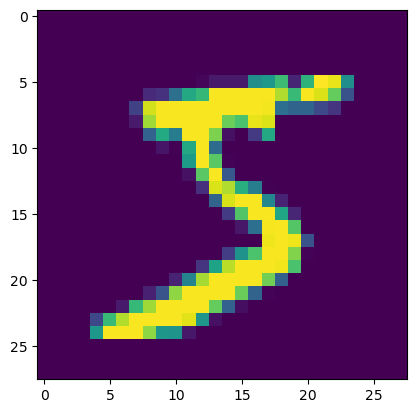

In [46]:
plt.imshow(X_train[0])

In [47]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## Reshape and Rescale Images for DCGAN

Generator will use tanh activation function for the last layer, so we want to reshape X_train to be within -1 to 1 limits.

In [48]:
X_train = X_train/255

In [49]:
X_train.shape

(60000, 28, 28)

In [50]:
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1. #to match the [-1,1] range eturned by generator, -1 dimention means that the value should be inferred

In [51]:
X_train.min()

-1.0

In [52]:
X_train.max()

1.0

## Filtering out the Data for Faster Training on Smaller Dataset

In [53]:
only_zeros = X_train[y_train==0]

In [54]:
only_zeros.shape

(5923, 28, 28, 1)

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Dropout,LeakyReLU,Flatten,BatchNormalization,Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [56]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 100 #Size of the random noise vector supplied to generator

In [57]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
        layers.Reshape([7, 7, 128]),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same",activation="relu"),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same",activation="tanh")
    ]) #We have one output for given image
    return model

In [58]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, kernel_size=5, strides=2, padding="same",activation=LeakyReLU(0.3),input_shape=[28, 28, 1]),
        layers.Dropout(0.5),
        layers.Conv2D(128, kernel_size=5, strides=2, padding="same",activation=LeakyReLU(0.3)),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model


In [59]:
generator = build_generator()
discriminator = build_discriminator()

In [60]:
GAN = Sequential([generator, discriminator])

In [61]:
discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False #So that the discriminator weights don't get updated when training generator

In [62]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [63]:
GAN.layers

In [64]:
GAN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 28, 28, 1)         840705    
                                                                 
 sequential_4 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________


In [65]:
GAN.layers[0].summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 64)       204864    
 ranspose)                                                       
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                      

In [66]:
GAN.layers[1].summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 0
Non-trainabl

### Setting up Training Batches

In [67]:
import tensorflow as tf

In [68]:
batch_size = 32

In [69]:
# my_data = X_train
my_data = only_zeros

In [70]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [71]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [72]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1) # Drop reminder gets rid of reminder data 5923/32 =185.09375

In [73]:
epochs = 20

## Training Loop

In [74]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%20 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            

Currently on Epoch 1
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185
	Currently on batch number 160 of 185
	Currently on batch number 180 of 185
Currently on Epoch 2
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185
	Currently on batch number 160 of 185
	Currently on batch number 180 of 185
Currently on Epoch 3
	Currently on batch number 20 of 185
	Currently on batch number 40 of 185
	Currently on batch number 60 of 185
	Currently on batch number 80 of 185
	Currently on batch number 100 of 185
	Currently on batch number 120 of 185
	Currently on batch number 140 of 185

In [75]:
noise = tf.random.normal(shape=[10, codings_size])

In [76]:
noise.shape

TensorShape([10, 100])

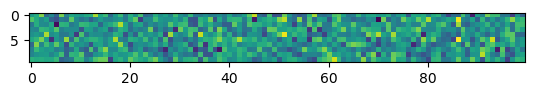

In [77]:
plt.imshow(noise)

In [78]:
images = generator(noise)

In [79]:
single_image = images[0]

In [80]:
# single_image.numpy().reshape(28,28)

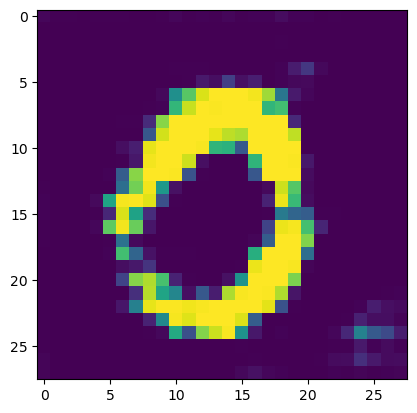

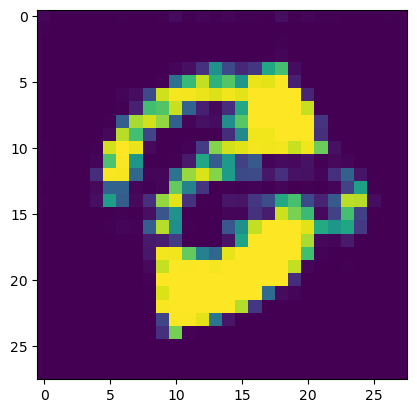

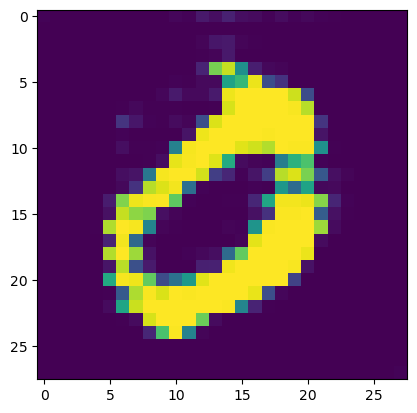

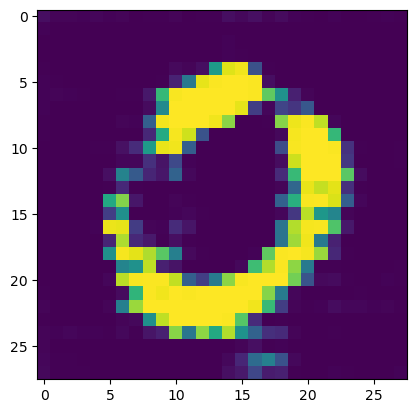

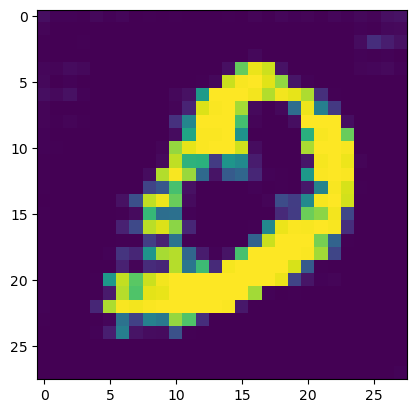

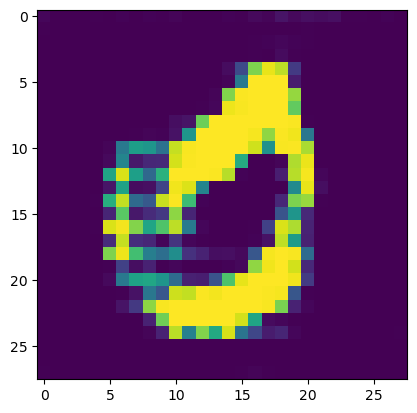

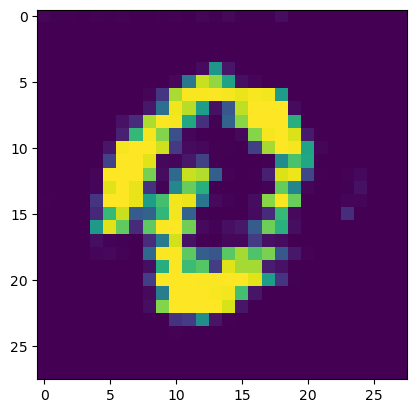

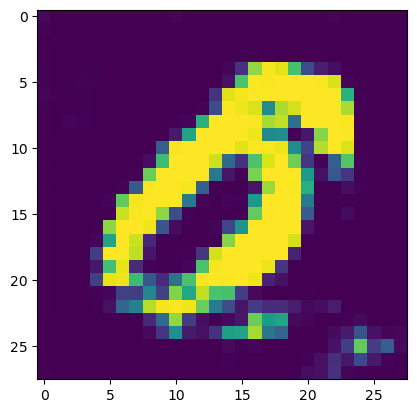

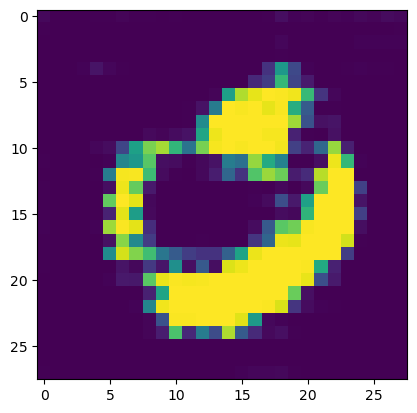

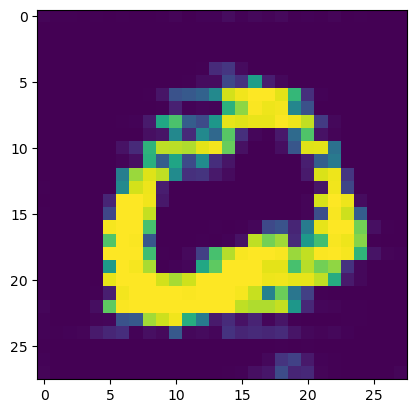

In [81]:
for image in images:
    plt.imshow(image.numpy().reshape(28,28))
    plt.show()